In [24]:
from CrocOpp import CrocOpp
from crocO import set_options
import datetime
from math import trunc
import os
from postes.explore_metadata import find_name_station
from scores.ensemble import EnsembleScores
from utilcrocO import Pgd
from utilpp import RMSE, spread

import matplotlib.pyplot as plt
import numpy as np


# ########## PARAMS ##########################
run = 'global'  # 'ol' for openloop
nens = 40
neff = 7
assimvars = 'DEP'
year = 2015
assimilate_every = 7
vconf = 'postes_8_9_12_13_15_16_csv'
selMassif = [12]
tartes =[ '', '_NoT']  # '' for tartes openloop, '_NoT' without
##############################################

# preparation
sensorBase= '_'.join(list(map(str, selMassif)))
pgdPath= os.environ['VORTEXPATH'] + '/s2m/' + \
    vconf + '/spinup/pgd/PGD_' + vconf + '.nc'
pgd= Pgd(pgdPath)

# generate runs on beaufix
classesId= np.array([i for i, m in enumerate(pgd.massif) if m in selMassif])
# sort classes per altitude:
classesId= classesId[np.argsort(pgd.elev[classesId])]

xps= {str(sensorBase): str(sensorBase)}
print(xps)
curdir = os.getcwd()
print(curdir)
runs= dict()
for t in tartes:
    station=sensorBase
    print('sensor', xps[station], 'openloop', tartes)
    args= [
        '/home/cluzetb/snowtools_git/assim/crocO.py',
        '--xpid', '{0}_{1}_{2}_{3}_{4}_{5}'.format(
            year, run, nens, xps[station], neff, assimilate_every),
        '--xpidol', '{0}_ol_40'.format(year) + t,
        '--sensor', xps[station],
        '--vconf', 'postes_8_9_12_13_15_16_csv',
        '-d', 'all',
        '--vars', 'DEP',
        '--ppvars', 'DEP',
        '-o', 'beaufix',
        # '--readprep',
        '--readobs',
        '--readaux',
        '--readoper',
        ]
    options, conf = set_options(args)

    runs[t] = CrocOpp(options, conf)
os.chdir(curdir)

{'12': '12'}
/home/cluzetb/Documents/these/assim/postes/notebooks
sensor 12 openloop ['', '_NoT']
('loading from pickle ! ', 'ensProAn.pkl')
('loading from pickle ! ', '/home/cluzetb/Documents/these/vortexpath/s2m/postes_8_9_12_13_15_16_csv/2015_ol_40//crocO/beaufix/ensProOl.pkl')
reading real assimilated obs. in /home/cluzetb/Documents/these/vortexpath/s2m/postes_8_9_12_13_15_16_csv/obs/12/
reading observation timeseries (pickle from csv file)
('loading from pickle ! ', '/home/cluzetb/Documents/these/vortexpath/s2m/postes_8_9_12_13_15_16_csv/obs/12/obs_12_postes_8_9_12_13_15_16_csv_2013010106_2018123106.pkl')
('loading from pickle ! ', '/home/cluzetb/Documents/these/vortexpath/s2m/postes_8_9_12_13_15_16_csv/oper_2015/crocO/beaufix/oper.pkl')
sensor 12 openloop ['', '_NoT']
('loading from pickle ! ', 'ensProAn.pkl')
('loading from pickle ! ', '/home/cluzetb/Documents/these/vortexpath/s2m/postes_8_9_12_13_15_16_csv/2015_ol_40_NoT//crocO/beaufix/ensProOl.pkl')
reading real assimilated ob

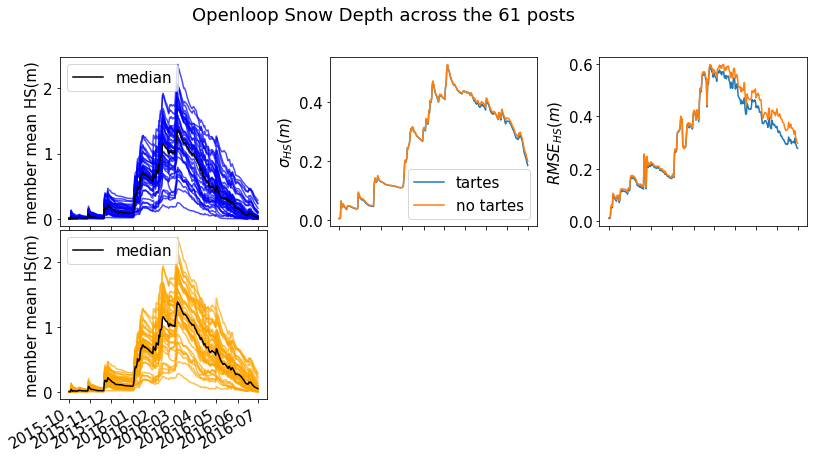

In [25]:
%matplotlib inline
spreadOl = {}
RMSEOl = {}
plt.rcParams.update({'font.size': 15})

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 7))
plt.subplots_adjust(wspace=.3,hspace=.02, right=.99)
for t in tartes:
    run = runs[t]
    mobs = [i for i, t in enumerate(run.obsTs['time'])
            if (t.hour == 6 and ((t.year == year and t.month > 9) or (t.month < 7 and t.year == year + 1)))]
    mensOl = [i for i, t in enumerate(run.ensProOl['time']) if (
        t.hour == 6 and (t.month > 9 or t.month < 7))]
    obs = np.ma.masked_invalid(run.obsTs['DEP'][mobs, :])
    ensOl = run.ensProOl['DEP'][mensOl, :, :]
    spreadOl[t] = spread(ensOl)
    RMSEOl[t] = RMSE(ensOl, obs)

    # plot
    if t == '':
        ax = axs[0, 0]
        ax.plot(run.ensProOl['time'][mensOl], np.mean(ensOl, axis=1),
                color='b', alpha=0.7)
    else:
        ax = axs[1, 0]
        ax.plot(run.ensProOl['time'][mensOl], np.mean(ensOl, axis=1),
                color='orange', alpha=0.7)
    ax.plot(run.ensProOl['time'][mensOl], np.mean(np.median(ensOl, axis=2), axis=1),
                color='k', label='median')
    ax.set_ylabel('member mean HS(m)')
    _=ax.legend()
    ax = axs[0, 1]
    ax.plot(run.ensProOl['time'][mensOl],  spreadOl[t],
            label='tartes' if t == '' else 'no tartes')
    ax.set_ylabel(r'$\sigma_{HS}(m)$')
    _=ax.legend()

    ax = axs[0, 2]
    ax.plot(run.ensProOl['time'][mensOl], RMSEOl[t],
            label='tartes' if t == '' else 'no tartes')
    ax.set_ylabel(r'$RMSE_{HS}(m)$')
    fig.autofmt_xdate()
axs[1,1].axis('off')
axs[1,2].axis('off')
_=fig.suptitle(
    'Openloop Snow Depth across the {0} posts'.format(pgd.npts))

plt.savefig('spread_T_NoT_{0}.pdf'.format(year))
plt.savefig('spread_T_NoT_{0}.png'.format(year), dpi=200)